In [1]:
import os
import shutil#
os.chdir('/content')
! git clone --branch errors https://github.com/mwl10/hetvae
os.chdir('/content/hetvae')
! pip install -r requirements.txt
os.chdir('/content/hetvae/src')
import numpy as np
import torch
import torch.optim as optim
import models
from argparse import Namespace
import torch.optim as optim
import utils
import my_utils
import pandas as pd
import importlib
import vae_models
from glob import glob
import matplotlib.pyplot as plt
import sys
from dataset import DataSet
%matplotlib inline

Cloning into 'hetvae'...
remote: Enumerating objects: 3856, done.
remote: Counting objects: 100% (892/892), done.
remote: Compressing objects: 100% (847/847), done.
remote: Total 3856 (delta 122), reused 93 (delta 45), pack-reused 2964
Receiving objects: 100% (3856/3856), 30.89 MiB | 15.28 MiB/s, done.
Resolving deltas: 100% (1067/1067), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 210 kB 7.3 MB/s 
     |████████████████████████████████| 81 kB 6.8 MB/s 
     |████████████████████████████████| 149 kB 17.5 MB/s 
     |████████████████████████████████| 78 kB 3.3 MB/s 
     |████████████████████████████████| 15.7 MB 364 kB/s 
     |████████████████████████████████| 308 kB 35.5 MB/s 
     |████████████████████████████████| 112 kB 36.9 MB/s 
     |████████████████████████████████| 2.1 MB 31.8 MB/s 
     |████████████████████████████████| 596 kB 9.2 MB/s 
     |████████████████████████████████|

In [113]:
#--------------------------------------------------------------------------------------------------------
# PREPROCESSING, from Edelson data 
#--------------------------------------------------------------------------------------------------------
lc_files = glob('/content/hetvae/data/EDELSON/*')

# hypers: 
Edelson = DataSet() \
            .add_files(lc_files) \
            .files_to_numpy() \
            .handle_dups() \
            .prune_graham(plot=True, index=0,std_threshold=1) \
            .resample_dataset(num_samples=9) \
            .normalize() \
            .reorder() \
            .set_union_x() \
            .zero_fill() \
            .error_to_sample_weight() \
            .make_masks(frac=0.33)

print(
    Edelson.files, '\n',
    Edelson.union_x.shape,
    Edelson.dataset.shape,
    Edelson.subsampled_mask.shape,
    Edelson.recon_mask.shape
  )

# plt.scatter(Edelson.dataset[1,:-100,0], Edelson.dataset[1,:-100,1])
# Edelson.union_x.shape

/content/hetvae/data/EDELSON/NGC5548_W1.dat
43


IsADirectoryError: ignored

In [2]:
#------------------------------
# AGN Preprocessing, we have a DF w/ OBJECT , FILTER, MJD, FLUX, ERROR
#------------------------------

agn_df = pd.read_csv('/content/hetvae/data/AGN_1H2106-099/1H2106-099_latest_lcs_pyroa.csv')
# handle formatting for new AGN
lcs = []
for lc_df in agn_df.groupby('Filter'):
    lc = lc_df[1][['MJD', 'Flux', 'Error']].to_numpy()
    lcs.append(lc)
# lcs[0] = lcs[0][lcs[0][:,0].argsort()]
# lcs[0] = np.concatenate((lcs[0][:10], lcs[0][410:]))
lcs = [lcs[0]]

# lcs = [lcs[0], lcs[0]]
AGN_1H2106 = DataSet()
AGN_1H2106.dataset = lcs # skip add files part

AGN_1H2106 = AGN_1H2106.handle_dups() \
                      .prune_outliers() \
                      .resample_dataset(num_samples=5) \
                      .normalize(normalize_y='individual', normalize_x='individual', x_by_range=True, y_by_range=False) \
                      .reorder() \
                      .set_union_x() \
                      .zero_fill() \
                      .error_to_sample_weight() \
                      .make_masks(frac=0.5) \
                      .set_target_x()


print(
    AGN_1H2106.union_x.shape,
    AGN_1H2106.dataset.shape,
    AGN_1H2106.subsampled_mask.shape,
    AGN_1H2106.recon_mask.shape
  )


# fig,ax = plt.subplots(5,1, figsize=(20,20))
# for i in range(5):
#     ax[i].scatter(AGN_1H2106.dataset[i,:-50,0], AGN_1H2106.dataset[i,:-50,1])

indexes of outliers to be pruned, if any: [600 601]
generating 5 new sample of each example in the dataset & appending them 
 old dataset length: 1
new dataset length: 6
created union_x attribute of length 619
zero fill all the examples up to the length of longest one given, dataset is also now a numpy array w shape: (6, 619, 3), instead of a list of numpy arrays
created subsampled_mask & recon_mask instance attributes
(619,) (6, 619, 3) (6, 619) (6, 619)


In [3]:
args = Namespace(batch_size=8, bound_variance=False, const_var=False,dropout=0.3, 
                 elbo_weight=1, embed_time=32, enc_num_heads=4, intensity=True, k_iwae=1, kl_annealing=False, 
                 kl_zero=False, latent_dim=64, lr=0.001, mixing='concat_and_mix', mse_weight=2., net='hetvae', 
                 niters=1000, norm=True, normalize_input='znorm', num_ref_points=64, rec_hidden=64, recon_loss=False, 
                 sample_tp=0.33, save=True, seed=0, shuffle=True, std=0.1, var_per_dim=False, width=64)



In [4]:
DIM = 1
# definitly want a decaying error rate...
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[], gamma=0.1)
seed = args.seed
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
LightCurves = np.concatenate((AGN_1H2106.dataset, AGN_1H2106.subsampled_mask[:,:,np.newaxis], AGN_1H2106.recon_mask[:,:,np.newaxis]), axis=-1) # format the masks for the model 
#LightCurves = np.concatenate((AGN_1H2106.dataset, AGN_1H2106.subsampled_mask[:,:,np.newaxis], AGN_1H2106.recon_mask[:,:,np.newaxis]), axis=-1) # format the masks for the model 
#LightCurves = np.concatenate((Catalina.dataset, Catalina.subsampled_mask[:,:,np.newaxis], Catalina.recon_mask[:,:,np.newaxis]), axis=-1) # format the masks for the model 

print(LightCurves.shape)


(6, 619, 5)


In [6]:
training, valid = np.split(LightCurves, [int(np.floor(0.8*len(LightCurves)))])# shuffle?

train_loader = torch.utils.data.DataLoader(training, batch_size=args.batch_size)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=args.batch_size)
       

In [8]:
net = models.load_network(args, DIM, torch.Tensor(AGN_1H2106.union_x))
#net = models.load_network(args, DIM, torch.Tensor(Edelson.union_x))  
params = list(net.parameters())
optimizer = optim.Adam(params, lr=0.002057519)

In [9]:
def train(net, optimizer,epoch, train_loader, args, device="cuda"):
      
      train_loss = 0.
      train_n = 0.
      avg_loglik, avg_kl, mse, mae = 0., 0., 0., 0.
      for i, train_batch in enumerate(train_loader):
          batch_len = train_batch.shape[0] 
          #train_batch[:,:,2] = torch.ones((train_batch[:,:,3].shape))
          train_batch = train_batch.to(device)
          x = train_batch[:,:,0]
          y = train_batch[:,:,1:2]
          subsampled_mask = train_batch[:,:,3:4]
          recon_mask = train_batch[:,:,4:5]
          sample_weight = train_batch[:,:,2:3]
          # weights for loss in analogy to standard weighted least squares error 
  
          seqlen = train_batch.size(1) 
          # subsampled flux values and their corresponding masks....
          context_y = torch.cat((
              y * subsampled_mask, subsampled_mask
          ), -1) 
          recon_context_y = torch.cat((            # flux values with only recon_mask values showing
                  y * recon_mask, recon_mask
              ), -1) 
    # format: compute_unsupervised_loss(self, context_x, context_y, target_x, target_y, num_samples=1, beta=1):
          loss_info = net.compute_unsupervised_loss(
              x,
              context_y,  
              x,  # can pick the points we want to project to
              recon_context_y,
              num_samples=args.k_iwae, # 1? 
              beta=0.1,
              # optional, will be zero if not set
              sample_weight = 1., #sample_weight,

          )
          optimizer.zero_grad()
          loss_info.composite_loss.backward()
          optimizer.step()
          #scheduler.step()
          train_loss += loss_info.composite_loss.item() * batch_len
          avg_loglik += loss_info.loglik * batch_len
          avg_kl += loss_info.kl * batch_len
          mse += loss_info.mse * batch_len
          mae += loss_info.mae * batch_len
          train_n += batch_len
      
      
      if epoch % 100 == 0:
          print(
              'Iter: {}, train loss: {:.4f}, avg nll: {:.4f}, avg kl: {:.4f}, '
              'mse: {:.6f}, mae: {:.6f}'.format(
                  epoch,
                  train_loss / train_n,
                  -avg_loglik / train_n,
                  avg_kl / train_n,
                  mse / train_n,
                  mae / train_n
              )
          )


In [ ]:
for g in optimizer.param_groups:
    print(g['lr'])
    g['lr'] = 0.00257519

0.002057519


In [34]:
AGN_1H2106.set_target_x(num_points=200)
recons = []

In [35]:

for epoch in range(1, 101): #args.niters + 1):
    train(net, optimizer, epoch, train_loader, args)
    if epoch % 10 == 0 or epoch == 1:
        reconstruction, qz_mean, qz_std = viz_per_example(AGN_1H2106.dataset[0], AGN_1H2106.target_x[0], net, num_points=200, device=device, k_iwae=50)
        recons.append(reconstruction)

Iter: 100, train loss: 1.4865, avg nll: 0.7342, avg kl: 0.0869, mse: 0.371799, mae: 0.459479


In [61]:
AGN_1H2106.error_to_sample_weight()

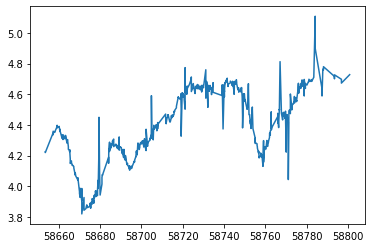

In [62]:
# denormalize reconstructions and the example we're going to animate

i = 0
xmean, xstd = AGN_1H2106.x_mean_std[i]
ymean, ystd = AGN_1H2106.y_mean_std[i]

denorm_recons = []

for recon in recons:
    denorm_recon = recon.copy()
    denorm_recon[:,0] = (denorm_recon[:,0] * xstd) + xmean
    denorm_recon[:,1] = (denorm_recon[:,1] * ystd) + ymean
    denorm_recon[:,2] = denorm_recon[:,2] * ystd
    denorm_recons.append(denorm_recon)


ex= AGN_1H2106.dataset[i].copy()

ex[:,0] = (ex[:,0] * xstd) + xmean
ex[:,1] = (ex[:,1]) * ystd + ymean
ex[:,2] = ex[:,2] * ystd

plt.plot(ex[:,0], ex[:,1])
# plt.plot(recons[0][:,0], recons[0][:,1])

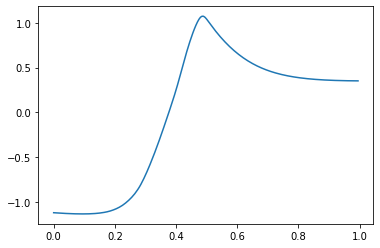

In [53]:
plt.plot(recons[10][:,0], recons[10][:,1])

In [15]:
from matplotlib.animation import FuncAnimation
from matplotlib import rc
rc('animation', html='jshtml')

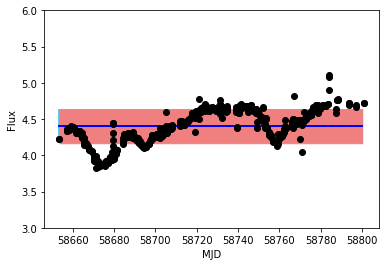

In [63]:
fig, ax = plt.subplots()
def animate(i):
    x = denorm_recons[i][:,0]
    y = denorm_recons[i][:,1]
    yerr = denorm_recons[i][:,2]

    ax.clear()
    w=2.0
    ax.fill_between(x, y - yerr, y+yerr, color='lightcoral', zorder=30)
    ax.plot(x, y, c='b', lw=w, label='Reconstructions', zorder=40)
    ax.scatter(ex[:,0], ex[:,1], c='black', zorder=50)
    ax.errorbar(x, y ,yerr=yerr,  ecolor='#65c9f7', c='b', lw=w, label='Reconstructions')
    #ax.set_xlim([0,1])
    ax.set_ylim([3,6])
    ax.set_xlabel('MJD')
    ax.set_ylabel('Flux')

ani = FuncAnimation(fig, animate, frames=10, interval=150, repeat=False)

In [64]:
ani

In [13]:
# visualisation for one light curve w/ increasing number of points
def viz_per_example(example, target_x, net, num_points=40, device="cuda", k_iwae=10, frac=0.5): 
    example = example[np.newaxis, :,:]
    target_x = target_x[np.newaxis, :, np.newaxis]
    np.random.seed(0)
    with torch.no_grad(): 
        if torch.is_tensor(example):
            example = example.cpu().numpy()
        # make new masks relative to fraction of points we got to predict w/ 
        smask, rmask = my_utils.make_masks(example, frac=frac)
        example = np.concatenate((example, smask[:,:,np.newaxis], rmask[:,:,np.newaxis], target_x), axis=-1) # format the masks 
        
        example = torch.tensor(example)
        example = example.to(device)
        
        subsampled_mask = example[:,:,3:4]
        context_y = torch.cat((example[:,:, 1:2] * subsampled_mask, subsampled_mask), -1)
        px, qz = net.get_reconstruction(example[:,:, 0], context_y, example[:,:,5], num_samples=k_iwae)

        qz_mean = (qz.mean.cpu().numpy())
        qz_std = (torch.exp(0.5 * qz.logvar).cpu().numpy())
        px_mean = px.mean.cpu().numpy()
        px_std = torch.exp(0.5 * px.logvar).cpu().numpy()
        example = example.cpu().numpy()

        px_mean = np.mean(px_mean, axis=0)[0,:num_points,0]
        px_std = np.mean(px_std, axis=0)[0,:num_points,0]
        target_x = target_x[0,:num_points,0]
        w=2.0
        #plt.figure(figsize=(30, 10))
        #plt.fill_between(target_x, px_mean - 2*px_std, px_mean+2*px_std, color='gray')

        # plt.plot(target_x, px_mean, c='b', lw=w, label='Reconstructions', zorder=20)
        # plt.scatter(example[0,:,0], example[0,:,1])
        # plt.errorbar(target_x, px_mean ,yerr=px_std,  ecolor='#65c9f7', c='b', lw=w, label='Reconstructions')

        #plt.show()
        reconstruction = np.concatenate((target_x[:,np.newaxis], px_mean[:,np.newaxis], px_std[:,np.newaxis]), axis=1)
        #print(f'qz shape: {qz_mean.shape}')
        #print(f'reconstructed example: {reconstruction.shape}')
        return reconstruction, qz_mean,qz_std

